## Pipeline to combine models

### Import

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import mlflow
from mlflow.transformers import log_model
import logging 
from mlflow.sklearn import save_model
import torch

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from mlflow.models.signature import infer_signature
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
from scipy.special import softmax
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoModel, AutoTokenizer, AutoConfig


from torch import nn
import mlflow.pytorch

import sentencepiece
import os
import config

/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import (
    get_preprocess_data,
    get_lemmatized_data,
    tokenize,
    TextDataset,
    get_metrics
)

### Setup


In [3]:
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

### Prepare for LogReg

In [4]:
def get_vectorizer(data_path):
    df = get_preprocess_data(data_path)
    df = get_lemmatized_data(df)

    X = df['text']
    y = df['logical_fallacies']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y)

    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),  # Bigrams (or even trigrams)
        max_features=1000,   # Limit feature space to the most important words
        min_df=5,            # Consider words that appear in at least 5 documents
        max_df=0.9)       # Ignore words that appear in more than 90% of documents)
        
    return tfidf_vectorizer.fit(X_train)



In [5]:
binary_vectorizer = get_vectorizer("../data/data_binary.csv")
binary_emotion_hominem_vectorizer = get_vectorizer("../data/data_binary_emotion_hominem.csv")
multiclass_with_vectorizer = get_vectorizer("../data/data_multiclass_with_none.csv")
multiclass_without_vectorizer = get_vectorizer("../data/data_multiclass_without_none.csv")

In [6]:
def get_vectorized_text(df, problem_type):

    df['text'] = df['text'].apply(lambda x: x.lower())
    df = get_lemmatized_data(df)

    # if (problem_type == 'multiclass_with') or (problem_type == 'multiclass_without'):
    #     y = df['logical_fallacies']
    # else:
    #     y = df['two_class_target']
    X = df['text']

    if problem_type == 'multiclass_with':
        X_vectorized = multiclass_with_vectorizer.transform(X)
    elif problem_type == 'multiclass_without':
        X_vectorized = multiclass_without_vectorizer.transform(X)
    elif problem_type == 'binary':
        X_vectorized = binary_vectorizer.transform(X)
    else:
        X_vectorized = binary_emotion_hominem_vectorizer.transform(X)

    return X_vectorized


### Prepare for DistilBert

In [7]:
# le = LabelEncoder()
# y = df['logical_fallacies']
# # y = df['two_class_target']
# y_encoded = le.fit_transform(y)

def get_tokenized_text(df):
    X = df['text']
    x_tokenized = tokenize(X.to_list(), "distilbert-base-uncased")
    return x_tokenized


### Distilbert Prediction

In [8]:
## Function for prediction

def predict(model, encodings, batch_size=8):
    # Set the model to evaluation mode
    model.eval()
    
    # Use GPU
    device = torch.device("mps")
    model.to(device)
    
    # Perform inference
    probabilities = []
    for i in range(0, len(encodings["input_ids"]), batch_size):
        with torch.no_grad():
            batch = {
                key: val[i:i+batch_size].to(device) 
                for key, val in encodings.items()
            }
            outputs = model(**batch)
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
            probabilities.extend(probs)
            
        # Clear GPU memory after each batch
        torch.mps.empty_cache()
    
    return np.array(probabilities)

### Pipeline: Binary LogReg + Multiclass DistilBert

In [ ]:
MODEL_NAME = "binary_LogReg_multiclass_DistilBert" 

#setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "binary logreg multi distilbert")
mlflow.log_param("dataset", 'data_val')


#### 1. Step: Binary LogReg

In [ ]:
#Get Val-Data and prepare for binary logreg
df_val = pd.read_csv('../data/data_val.csv')
X_prep = get_vectorized_text(df_val, 'binary')

In [ ]:
#Import LogReg Binary Model
with open("../models/logreg_binary/logreg_binary.pkl", "rb") as file:
    logreg_binary = pickle.load(file)

In [ ]:
y_pred = logreg_binary.predict(X_prep)

In [ ]:
#Create dataframe for next step
df_first= df_val.copy()
df_first['pred_1'] = y_pred
df_second = df_first[df_first['pred_1']== 'fallacy']
df_first = df_first[df_first['pred_1'] == 'none']

#### 2.step: Distilbert Multiclass without none

In [ ]:
# prepare X for Distilbert
X_prep_2 = get_tokenized_text(df_second)

In [ ]:
#load Distilbert
path_pt = "../models/distilbert_multiclass_without_none/pytorch_model"
distilbert = mlflow.pytorch.load_model(path_pt)


In [ ]:
base_probs = predict(distilbert, X_prep_2, batch_size=2)

In [ ]:
def get_first_prediction(proba):
    preds = np.argmax(proba, axis=1)
    #pred_int = int(pred[0]) --> had to remove this, otherwise it took the same prediction for all
    probas = proba[np.arange(len(preds)), preds]
    #proba_int = float(proba[0])
    return preds, probas

In [ ]:
first_pred, first_proba = get_first_prediction(base_probs)

In [ ]:
#get encodings
df_encodings = pd.read_csv('../data/data_multiclass_without_none.csv')
y = df_encodings["logical_fallacies"]
le = LabelEncoder()
y_train = le.fit(y)

In [ ]:
df_second['pred_2'] = first_pred

In [ ]:
df_second['pred_2'] = le.inverse_transform(df_second['pred_2'])

In [ ]:
df_first['pred_2'] = df_first['pred_1']
df_result = pd.concat([df_first, df_second], ignore_index=True)

In [ ]:
df_result

#### Evaluation

In [ ]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                print(f"{split}_{key}_{metric}", round(value.get(metric),2))

In [ ]:
logger.info('get validation metrics for one-step approach')
classification_report_one_train = get_metrics(df_result['logical_fallacies'], df_result['pred_2'])
log_metrics(classification_report_one_train, 'val')

In [ ]:
mlflow.end_run()

### Pipeline: Binary LogReg + Multi LogReg

In [ ]:
MODEL_NAME = "binary_LogReg_multiclass_LogReg" 

#setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "binary logreg multi logreg")
mlflow.log_param("dataset", 'data_val')


#### 1. Step: Binary LogReg

In [ ]:
#Get Val-Data and prepare for binary logreg
df_val = pd.read_csv('../data/data_val.csv')
X_prep = get_vectorized_text(df_val, 'binary')

In [ ]:
#Import LogReg Binary Model
with open("../models/logreg_binary/logreg_binary.pkl", "rb") as file:
    logreg_binary = pickle.load(file)

In [ ]:
y_pred = logreg_binary.predict(X_prep)

In [ ]:
#Create dataframe for next step
# df_second = df_val.copy()
df_first= df_val.copy()
df_first['pred_1'] = y_pred
df_second = df_first[df_first['pred_1']== 'fallacy']
df_first = df_first[df_first['pred_1'] == 'none']

In [ ]:
df_first.head()

In [ ]:
df_second.head()

In [ ]:
df_second['pred_1'].unique()

In [ ]:
df_second['logical_fallacies'].value_counts()

#### 2.step: LogReg Multiclass without none

In [ ]:
#Get Val-Data and prepare for binary logreg
X_prep = get_vectorized_text(df_second, 'multiclass_without')

In [ ]:
#Import LogReg Binary Model
with open("../models/logreg_multi_without/logreg_multi_without.pkl", "rb") as file:
    logreg_multi_without = pickle.load(file)

In [ ]:
y_pred = logreg_multi_without.predict(X_prep)

In [ ]:
df_second['pred_2']=y_pred

In [ ]:
df_second = df_second.drop('source', axis=1)

In [ ]:
df_first= df_first.drop('source', axis=1)

In [ ]:
df_first['pred_2'] = df_first['pred_1']

In [ ]:
df_result = pd.concat([df_first, df_second], ignore_index=True)

In [ ]:
df_result

#### Evaluation

In [ ]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                print(f"{split}_{key}_{metric}", round(value.get(metric),2))

In [ ]:
logger.info('get validation metrics')
classification_report = get_metrics(df_result['logical_fallacies'], df_result['pred_2'])
log_metrics(classification_report, 'val')

In [ ]:
mlflow.end_run()

### Pipeline Binary & Multiclass Distilbert

In [9]:
df_val = pd.read_csv('../data/data_val.csv')

In [10]:
# prepare X for Distilbert
X_prep = get_tokenized_text(df_val)

INFO:basic_functions:create tokenizer & load model


#### Binary Model & Prediction

In [11]:
#load Distilbert
path_pt = "../models/distilbert_binary/pytorch_model"
distilbert_binary = mlflow.pytorch.load_model(path_pt)


In [12]:
base_probs = predict(distilbert_binary, X_prep, batch_size=2)

In [13]:
def get_first_prediction(proba):
    preds = np.argmax(proba, axis=1)
    #pred_int = int(pred[0]) --> had to remove this, otherwise it took the same prediction for all
    probas = proba[np.arange(len(preds)), preds]
    #proba_int = float(proba[0])
    return preds, probas

In [14]:
first_pred, first_proba = get_first_prediction(base_probs)

In [15]:
first_pred

array([0, 0, 1, ..., 0, 0, 0])

In [16]:
#get encodings
df_encodings = pd.read_csv('../data/data_binary.csv')
y = df_encodings["two_class_target"]
le = LabelEncoder()
y_train = le.fit(y)


In [17]:
df_ = df_val.copy()

In [18]:
df_['binary'] = first_pred

In [19]:
df_['proba_binary'] = first_proba

In [20]:
df_['binary'] = le.inverse_transform(df_['binary'])

In [21]:
df_.head()

,dataset,text,logical_fallacies,source,two_class_target,binary,proba_binary
0,3,Either the Prime Minister lets independent med...,false_dilemma,NaN,fallacy,fallacy,0.994316
1,3,Turkey really needs to get rid of Erdogan and ...,false_dilemma,NaN,fallacy,fallacy,0.978140
2,3,I understand Turkey s position here They can t...,false_dilemma,NaN,fallacy,none,0.975645
3,3,I don t know why the international community e...,false_dilemma,NaN,fallacy,none,0.981612
4,1,If it is very low for instance around one it m...,false_dilemma,http://business.financialpost.com/opinion/ross...,fallacy,none,0.929342


#### Multiclass Model & Prediction

In [22]:
#load Distilbert
path_pt = "../models/distilbert_multiclass_with_none/pytorch_model"
distilbert_multi = mlflow.pytorch.load_model(path_pt)


In [23]:
base_probs = predict(distilbert_multi, X_prep, batch_size=2)

In [24]:
def get_first_prediction(proba):
    preds = np.argmax(proba, axis=1)
    #pred_int = int(pred[0]) --> had to remove this, otherwise it took the same prediction for all
    probas = proba[np.arange(len(preds)), preds]
    #proba_int = float(proba[0])
    return preds, probas

In [25]:
first_pred, first_proba = get_first_prediction(base_probs)

In [26]:
first_pred

array([3, 3, 4, ..., 1, 5, 5])

In [27]:
#get encodings
df_encodings = pd.read_csv('../data/data_multiclass_with_none.csv')
y = df_encodings["logical_fallacies"]
le = LabelEncoder()
y_train = le.fit(y)


In [28]:
df_['multi'] = first_pred

In [29]:
df_['multi'] = le.inverse_transform(df_['multi'])

In [30]:
df_['proba_multi'] = first_proba

In [31]:
df_ = df_.drop('source', axis=1)

In [32]:
df_.head()

,dataset,text,logical_fallacies,two_class_target,binary,proba_binary,multi,proba_multi
0,3,Either the Prime Minister lets independent med...,false_dilemma,fallacy,fallacy,0.994316,false_dilemma,0.986405
1,3,Turkey really needs to get rid of Erdogan and ...,false_dilemma,fallacy,fallacy,0.978140,false_dilemma,0.982732
2,3,I understand Turkey s position here They can t...,false_dilemma,fallacy,none,0.975645,none,0.682201
3,3,I don t know why the international community e...,false_dilemma,fallacy,none,0.981612,none,0.891897
4,1,If it is very low for instance around one it m...,false_dilemma,fallacy,none,0.929342,none,0.497294


In [36]:
df_['binary_eval'] = df_['two_class_target'] == df_['binary']

In [37]:
df_['multi_eval'] = df_['logical_fallacies'] == df_['multi']

In [57]:
def getAgreement(binary, multi):
    eval = []
    for i, value in enumerate(binary):
        if (binary[i] == 'fallacy'):
            if (multi[i]!= 'none'):
                eval.append(True)
            else: eval.append(False)
        else:
            if(multi[i] == 'none'):
                eval.append(True)
            else: eval.append(False)
    return eval

In [60]:
df_['agree']= getAgreement(df_['binary'], df_['multi'])

In [ ]:
### Get Values which are wrongly predicted, but both (binary and multi) gave a wrong prediction
### multi_eval == false
### agree == True

In [71]:
df_wrong = df_[(df_['multi_eval'] == False)&(df_['agree']==True)]
df_wrong.sort_values(by='binary_eval')

,dataset,text,logical_fallacies,two_class_target,binary,proba_binary,multi,proba_multi,binary_eval,multi_eval,agree
2,3,I understand Turkey s position here They can t...,false_dilemma,fallacy,none,0.975645,none,0.682201,False,False,True
478,8,Testing on animals could save the life of you ...,appeal_to_emotion,fallacy,none,0.605331,none,0.676041,False,False,True
476,4,Covid 19 is a scam It s the flu and hydroxychl...,appeal_to_emotion,fallacy,none,0.933915,none,0.850515,False,False,True
800,8,Letting everyone vote is a bad idea,none,none,fallacy,0.993612,appeal_to_emotion,0.823450,False,False,True
472,4,Why don t we see a scientific natural immunity...,appeal_to_emotion,fallacy,none,0.964717,none,0.748347,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
573,2,No one should believe our dear lady Senator wh...,ad_hominem,fallacy,fallacy,0.996901,appeal_to_emotion,0.588560,True,False,True
578,8,If you are dumb enough to want to kill yoursel...,ad_hominem,fallacy,fallacy,0.995127,false_dilemma,0.874794,True,False,True
579,2,Primitive people believed in gods to explain n...,ad_hominem,fallacy,fallacy,0.985629,appeal_to_emotion,0.495045,True,False,True
536,9,Now as to why I should be and he shouldn t be ...,ad_hominem,fallacy,fallacy,0.994771,appeal_to_authority,0.952265,True,False,True


In [73]:
df_wrong.groupby('logical_fallacies')[['logical_fallacies', 'binary','multi', 'agree'] ].value_counts()

logical_fallacies    binary   multi                agree
ad_hominem           fallacy  appeal_to_emotion    True     37
                              appeal_to_authority  True     27
                     none     none                 True     18
                     fallacy  false_dilemma        True      6
                              slippery_slope       True      2
appeal_to_authority  none     none                 True     22
                     fallacy  appeal_to_emotion    True     12
                              slippery_slope       True      9
                              false_dilemma        True      5
                              ad_hominem           True      3
appeal_to_emotion    none     none                 True     17
                     fallacy  ad_hominem           True     16
                              slippery_slope       True     11
                              appeal_to_authority  True      8
                              false_dilemma        True      

In [74]:
df_.head()

,dataset,text,logical_fallacies,two_class_target,binary,proba_binary,multi,proba_multi,binary_eval,multi_eval,agree
0,3,Either the Prime Minister lets independent med...,false_dilemma,fallacy,fallacy,0.994316,false_dilemma,0.986405,True,True,True
1,3,Turkey really needs to get rid of Erdogan and ...,false_dilemma,fallacy,fallacy,0.978140,false_dilemma,0.982732,True,True,True
2,3,I understand Turkey s position here They can t...,false_dilemma,fallacy,none,0.975645,none,0.682201,False,False,True
3,3,I don t know why the international community e...,false_dilemma,fallacy,none,0.981612,none,0.891897,False,False,True
4,1,If it is very low for instance around one it m...,false_dilemma,fallacy,none,0.929342,none,0.497294,False,False,True


In [77]:
df_one_right = df_[df_['agree'] == False]
df_one_right = df_one_right[(df_one_right['multi_eval']==True) | (df_one_right['binary_eval']==True)]

In [78]:
df_one_right.groupby('logical_fallacies')[['logical_fallacies', 'binary','multi', 'agree'] ].value_counts()

logical_fallacies    binary   multi                agree
ad_hominem           fallacy  none                 False    14
                     none     ad_hominem           False     8
appeal_to_authority  none     appeal_to_authority  False    46
                     fallacy  none                 False    16
appeal_to_emotion    fallacy  none                 False    14
                     none     appeal_to_emotion    False     6
false_dilemma        none     false_dilemma        False    38
                     fallacy  none                 False     4
none                 none     slippery_slope       False    28
                              appeal_to_emotion    False    13
                              false_dilemma        False    12
                     fallacy  none                 False    11
                     none     appeal_to_authority  False     8
                              ad_hominem           False     4
slippery_slope       none     slippery_slope       False    1

df_['agree'] == False]
df_one_right = df_one_right[(df_one_right['multi_eval']==True) | (df_one_right['binary_eval']==True)]

In [ ]:
def getWeights(df):
    weightedResults=[]
    for i, value in enumerate(df):
        if (df['agree']==False):
            if (df.loc[i,'multi'] == 'appeal_to_authority') |(df.loc[i,'multi'] == 'false_dilemma'):
                weightedResults.append(df.loc[i,'multi'])   

#### Evaluation

In [33]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                print(f"{split}_{key}", round(value,2))
                # mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                # mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                print(f"{split}_{key}_{metric}", round(value.get(metric),2))

In [80]:
df_.head()

,dataset,text,logical_fallacies,two_class_target,binary,proba_binary,multi,proba_multi,binary_eval,multi_eval,agree
0,3,Either the Prime Minister lets independent med...,false_dilemma,fallacy,fallacy,0.994316,false_dilemma,0.986405,True,True,True
1,3,Turkey really needs to get rid of Erdogan and ...,false_dilemma,fallacy,fallacy,0.978140,false_dilemma,0.982732,True,True,True
2,3,I understand Turkey s position here They can t...,false_dilemma,fallacy,none,0.975645,none,0.682201,False,False,True
3,3,I don t know why the international community e...,false_dilemma,fallacy,none,0.981612,none,0.891897,False,False,True
4,1,If it is very low for instance around one it m...,false_dilemma,fallacy,none,0.929342,none,0.497294,False,False,True


INFO:root:get validation metrics for binary & multiclass distilbert
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


              precision    recall  f1-score   support

     fallacy       0.95      0.78      0.85      1100
        none       0.45      0.81      0.58       250

    accuracy                           0.78      1350
   macro avg       0.70      0.80      0.72      1350
weighted avg       0.86      0.78      0.80      1350

[[856 244]
 [ 47 203]]


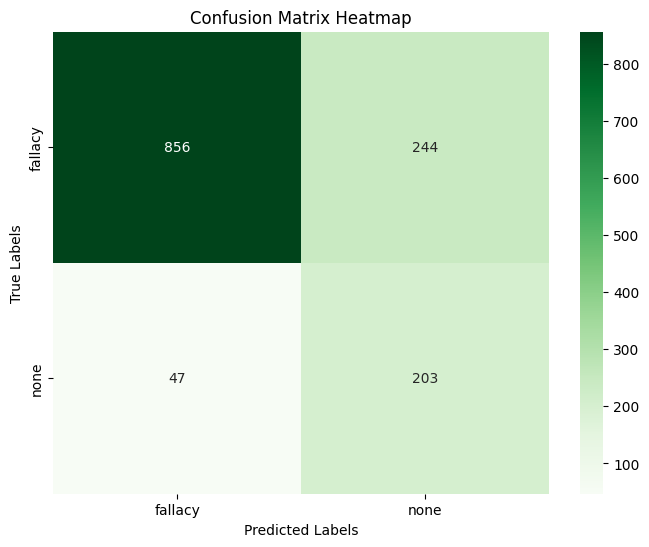

val_fallacy_precision 0.95
val_fallacy_recall 0.78
val_fallacy_f1-score 0.85
val_fallacy_support 1100
val_none_precision 0.45
val_none_recall 0.81
val_none_f1-score 0.58
val_none_support 250
val_accuracy 0.78
val_macro avg_precision 0.7
val_macro avg_recall 0.8
val_macro avg_f1-score 0.72
val_macro avg_support 1350
val_weighted avg_precision 0.86
val_weighted avg_recall 0.78
val_weighted avg_f1-score 0.8
val_weighted avg_support 1350


In [ ]:
logger.info('get validation metrics for binary distilbert on validation set')
classification_report_one_train = get_metrics(df_['two_class_target'], df_['binary'])
log_metrics(classification_report_one_train, 'val')

INFO:root:get validation metrics for binary & multiclass distilbert
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.82      0.55      0.66       250
appeal_to_authority       0.75      0.70      0.73       250
  appeal_to_emotion       0.66      0.68      0.67       250
      false_dilemma       0.80      0.75      0.78       250
               none       0.51      0.60      0.55       250
     slippery_slope       0.52      0.84      0.64       100

           accuracy                           0.67      1350
          macro avg       0.68      0.69      0.67      1350
       weighted avg       0.69      0.67      0.67      1350

[[137  31  39   9  32   2]
 [  3 176  12   8  38  13]
 [ 19   9 170   8  31  13]
 [  3   5   4 188  38  12]
 [  6  11  29  16 149  39]
 [  0   3   3   6   4  84]]


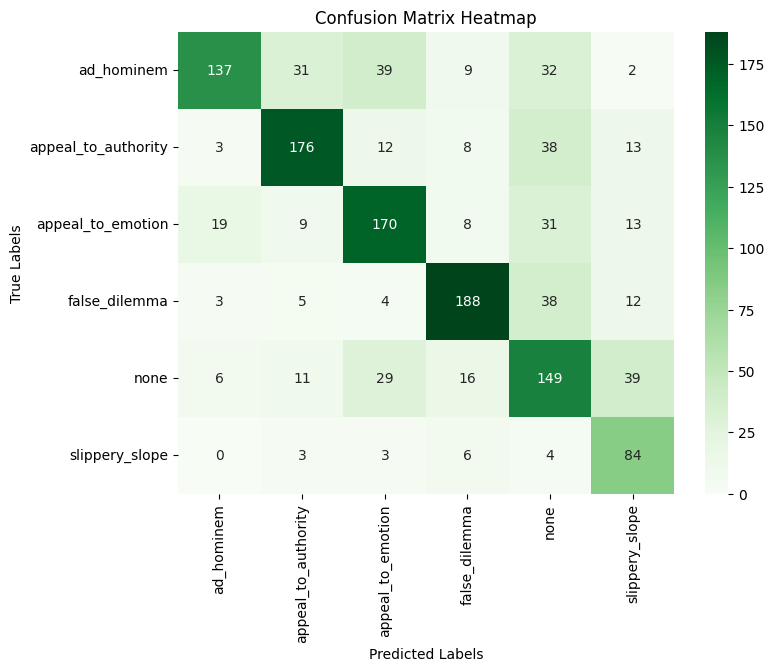

val_ad_hominem_precision 0.82
val_ad_hominem_recall 0.55
val_ad_hominem_f1-score 0.66
val_ad_hominem_support 250
val_appeal_to_authority_precision 0.75
val_appeal_to_authority_recall 0.7
val_appeal_to_authority_f1-score 0.73
val_appeal_to_authority_support 250
val_appeal_to_emotion_precision 0.66
val_appeal_to_emotion_recall 0.68
val_appeal_to_emotion_f1-score 0.67
val_appeal_to_emotion_support 250
val_false_dilemma_precision 0.8
val_false_dilemma_recall 0.75
val_false_dilemma_f1-score 0.78
val_false_dilemma_support 250
val_none_precision 0.51
val_none_recall 0.6
val_none_f1-score 0.55
val_none_support 250
val_slippery_slope_precision 0.52
val_slippery_slope_recall 0.84
val_slippery_slope_f1-score 0.64
val_slippery_slope_support 100
val_accuracy 0.67
val_macro avg_precision 0.68
val_macro avg_recall 0.69
val_macro avg_f1-score 0.67
val_macro avg_support 1350
val_weighted avg_precision 0.69
val_weighted avg_recall 0.67
val_weighted avg_f1-score 0.67
val_weighted avg_support 1350


In [ ]:
logger.info('get validation metrics for multiclass distilbert on validation set')
classification_report_one_train = get_metrics(df_['logical_fallacies'], df_['multi'])
log_metrics(classification_report_one_train, 'val')